## implementation stollen from https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/

In [3]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
%matplotlib inline
import matplotlib.pyplot as plt
import torchviz

In [18]:
def show_and_save(file_name,img):
    print(img.shape)
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)


In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)


In [15]:
# this is a descrete RBM
class RBM(nn.Module):
   def __init__(self,
               n_vis=784,
               n_hin=500,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))

   def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
   def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v

   def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_

   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [16]:
rbm = RBM(k=5)
train_op = optim.SGD(rbm.parameters(),0.01)
losses=[]

for epoch in range(10):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()
    losses.append(np.mean(loss_))
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Training loss for 0 epoch: -19.6923770904541
Training loss for 1 epoch: -15.035539627075195
Training loss for 2 epoch: -14.797597885131836
Training loss for 3 epoch: -13.698136329650879
Training loss for 4 epoch: -13.442554473876953
Training loss for 5 epoch: -12.751242637634277
Training loss for 6 epoch: -12.014920234680176
Training loss for 7 epoch: -11.473292350769043
Training loss for 8 epoch: -10.960468292236328
Training loss for 9 epoch: -10.396598815917969


In [ ]:
plt.plot(losses)

torch.Size([3, 122, 242])


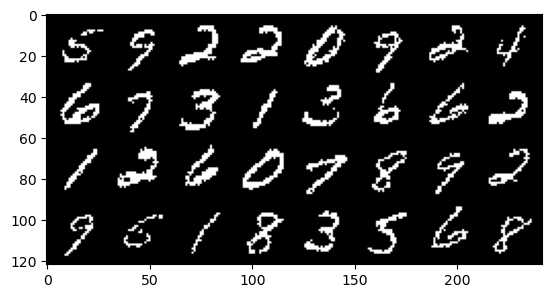

In [ ]:
show_and_save("real",make_grid(v.view(32,1,28,28).data))

torch.Size([3, 122, 242])


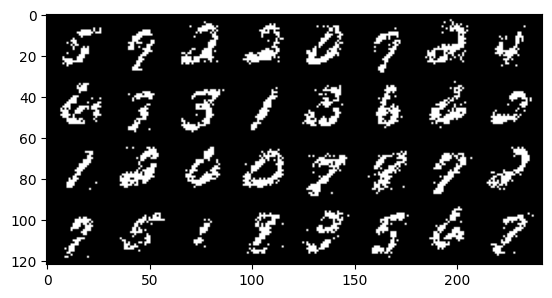

In [19]:
show_and_save("generate",make_grid(v1.view(32,1,28,28).data))


## Test on pfashion mnist

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.FashionMNIST('./dataFashion',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.FashionMNIST('./dataFashion',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)



(242, 242, 3)


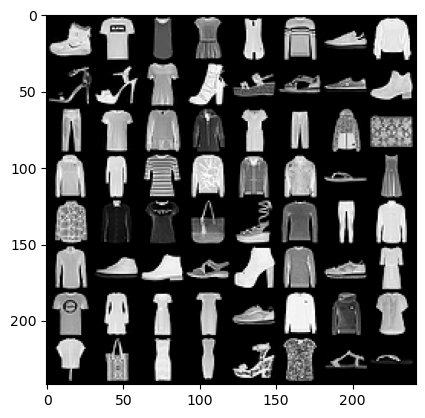

In [ ]:
for a,(data,target) in enumerate(train_loader):
    npimg = np.transpose(make_grid(data.view(64,1,28,28)).numpy(),(1,2,0))
    print(npimg.shape)
    plt.imshow(npimg)
    break

In [ ]:
print(npimg[10:20,10:20,0])

[[0.         0.00392157 0.00392157 0.00392157 0.         0.78431374
  0.9098039  0.9098039  0.9137255  0.8980392 ]
 [0.         0.         0.         0.         0.         0.7176471
  0.88235295 0.84705883 0.8745098  0.89411765]
 [0.         0.         0.         0.         0.         0.75686276
  0.89411765 0.85490197 0.8352941  0.7764706 ]
 [0.         0.00392157 0.01176471 0.         0.04705882 0.85882354
  0.8627451  0.83137256 0.85490197 0.7529412 ]
 [0.         0.         0.02352941 0.         0.3882353  0.95686275
  0.87058824 0.8627451  0.85490197 0.79607844]
 [0.         0.01568628 0.         0.         0.21568628 0.9254902
  0.89411765 0.9019608  0.89411765 0.9411765 ]
 [0.         0.         0.         0.         0.92941177 0.8862745
  0.8509804  0.8745098  0.87058824 0.85882354]
 [0.         0.24313726 0.5686275  0.8        0.89411765 0.8117647
  0.8352941  0.8666667  0.85490197 0.8156863 ]
 [0.7411765  0.89411765 0.8627451  0.87058824 0.8509804  0.8862745
  0.78431374 0.80

In [ ]:
rbm = RBM(k=1)
train_op = optim.SGD(rbm.parameters(),0.01)
losses=[]

NEPOCH=20

for epoch in range(NEPOCH):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        
    losses.append(np.mean(loss_))
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))

Training loss for 0 epoch: -23.03145980834961
Training loss for 1 epoch: -18.24848747253418
Training loss for 2 epoch: -16.415895462036133
Training loss for 3 epoch: -15.439300537109375
Training loss for 4 epoch: -14.758500099182129
Training loss for 5 epoch: -14.0410737991333
Training loss for 6 epoch: -13.209941864013672
Training loss for 7 epoch: -12.319907188415527
Training loss for 8 epoch: -11.546409606933594
Training loss for 9 epoch: -10.878767013549805
Training loss for 10 epoch: -10.122982025146484
Training loss for 11 epoch: -9.566575050354004
Training loss for 12 epoch: -8.930025100708008
Training loss for 13 epoch: -8.453506469726562
Training loss for 14 epoch: -8.033655166625977
Training loss for 15 epoch: -7.642439842224121
Training loss for 16 epoch: -7.2833027839660645
Training loss for 17 epoch: -6.921072483062744
Training loss for 18 epoch: -6.624309539794922
Training loss for 19 epoch: -6.3800764083862305


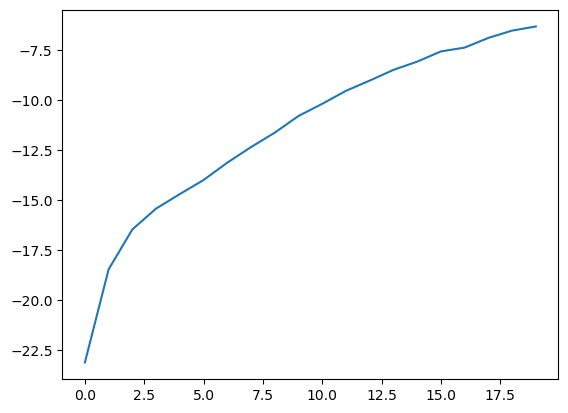

In [ ]:
plt.plot(losses)

torch.Size([3, 122, 242])


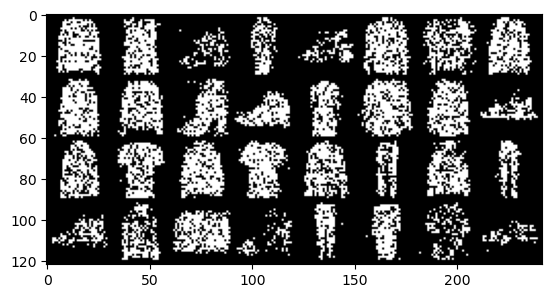

In [ ]:
show_and_save("generate_fashion",make_grid(v1.data.view(32,1,28,28)))

torch.Size([122, 242, 3])
tensor([[0., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
        [1., 1., 1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 0., 1., 1.]])
tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, Tr

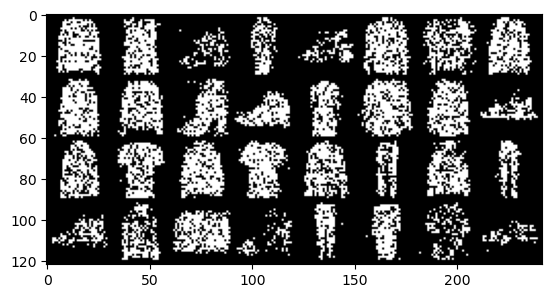

In [ ]:
npimg = np.transpose(make_grid(v1.data.view(32,1,28,28)),(1,2,0))
print(npimg.shape)
plt.imshow(npimg)
print(npimg[10:20,10:20,0])
print(npimg[10:20,10:20,0]==npimg[10:20,10:20,1])
print(npimg[10:20,10:20,0]==npimg[10:20,10:20,2])

In [1]:
# Continuous RBM
class RBM_C(nn.Module):
    def pin_to_minMax(self, tensor, limit=1):
        return torch.tanh(tensor/limit)*limit

    def __init__(self,
                n_vis=784,
                n_hin=500,
                k=5):
        torch.set_default_dtype(torch.double)
        super(RBM_C, self).__init__()
        
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        
        self.k = k
        
        self.eps=1e-18

    def v_to_h(self,v):
        p_h = torch.sigmoid(v.mul(self.W.t()) + self.h_bias)
        
        y = Variable(torch.rand(self.v_bias.size()))

        # TODO
        
        return y
    
    def h_to_v(self, h):
        p_v = torch.sigmoid(h.mul(self.W) + self.v_bias)
        
        y = Variable(torch.rand(self.v_bias.size()))

        # TODO

        return y

    def forward(self,v):
        h1 = self.v_to_h(v)
        
        h_ = h1
        for i in range(self.k):
            v_ = self.h_to_v(h_)
            h_ = self.v_to_h(v_)
        
        return v

    def free_energy(self,v):
        free =  - torch.sum(torch.matmul(v, self.v_bias)) - torch.trace(torch.matmul( F.linear(v, self.W), F.linear(v, self.W ).t()))
        return free
    
    def gradient_step(self, v0, v1, h0, h1, lr=0.01, momentum=0.01):
        grad_W      = torch.matmul(h0.t(),v0).div(v0.shape[0]) - torch.matmul(h1.t(),v1).div(v1.shape[0])
        grad_h_bias = h0.mean(dim=0) - h1.mean(dim=0)
        grad_v_bias = v0.mean(dim=0) - v1.mean(dim=0)

        self.W      = nn.Parameter(self.W      - lr*grad_W)
        self.h_bias = nn.Parameter(self.h_bias - lr*grad_h_bias)
        self.v_bias = nn.Parameter(self.v_bias - lr*grad_v_bias)

        return self.free_energy(v)

NameError: name 'nn' is not defined

In [230]:
# this is a descrete RBM
class RBM_C2(nn.Module):
   def __init__(self,
                n_vis=784,
                n_hin=500,
                k=5):
        super(RBM_C2, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return torch.sigmoid(p + 2*(Variable(torch.rand(p.size())) - 0.5))

   def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
   def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
   def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()



In [231]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)


In [232]:
rbm = RBM_C2(k=2)
train_op = optim.SGD(rbm.parameters(),0.01)
losses=[]

NEPOCH=20

for epoch in range(NEPOCH):
    loss_ = []
    for i, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        
        if i > 100:
            break
        
    losses.append(np.mean(loss_))
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))

Training loss for 0 epoch: -3594.8465945235093
Training loss for 1 epoch: -12345.779928084257
Training loss for 2 epoch: -21219.772611804598
Training loss for 3 epoch: -30058.086872324853
Training loss for 4 epoch: -38865.22356574455
Training loss for 5 epoch: -47687.23070913841
Training loss for 6 epoch: -56488.68807778164
Training loss for 7 epoch: -65288.475142924326
Training loss for 8 epoch: -74080.06074755364
Training loss for 9 epoch: -82851.8450762135
Training loss for 10 epoch: -91622.91724870977
Training loss for 11 epoch: -100353.37562676017
Training loss for 12 epoch: -109134.65307542594
Training loss for 13 epoch: -117961.42669104491
Training loss for 14 epoch: -126686.54361285799
Training loss for 15 epoch: -135473.25464897978
Training loss for 16 epoch: -144333.74697692678
Training loss for 17 epoch: -152926.5881432095
Training loss for 18 epoch: -161705.1236557682
Training loss for 19 epoch: nan


In [207]:
rbm = RBM_C2(k=1)
losses=[]
#optim = torch.optim.SGD(rbm.parameters(), lr=1e-2, momentum=0.9)

for epoch in range(10):
    loss_ = []
    for i, (data,_) in enumerate(train_loader):
        #train_op.zero_grad()
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1, h,h1 = rbm(sample_data)
        
        # with torch.no_grad.:
        loss = rbm.gradient_step(v, v1, h, h1)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        
        #grad_W = torch.autograd.backward(loss, rbm.W)
        #grad_h_bias = torch.autograd.backward(loss, rbm.h_bias)
        #grad_v_bias = torch.autograd.backward(loss, rbm.v_bias)
        
        #loss = rbm.free_energy(v) - rbm.free_energy(v1)
        #loss_.append(loss.data)
        #loss.backward()
        #train_op.step()
        
        loss_.append(loss.data)

        if i > 100:
            break

    losses.append(np.mean(loss_))
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))

ValueError: not enough values to unpack (expected 4, got 2)

torch.Size([3, 242, 242])


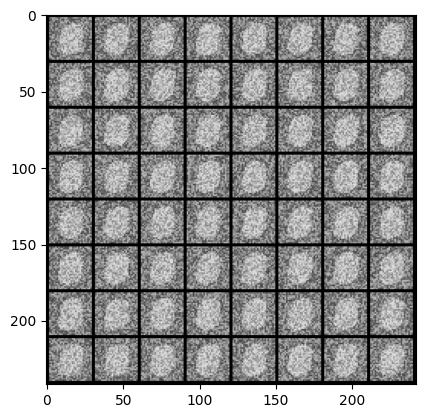

In [229]:
show_and_save("gen_rbm_c",make_grid(v1.view(64,1,28,28).data))